# **Random Imputation**

Random imputation involves replacing missing values with a **randomly selected value** from the same variable. This method preserves the variable's distribution but can introduce noise and bias if not used carefully.

- **Advantages**:
    - Simple to implement
    - Preserves the variable's distribution
    - Quick to compute
    - Well suited for linear models, as it **doesn't distort the distribution**, regardless of the % of NA
- **Disadvantages**:
    - Can introduce noise and bias
    - Does not account for relationships between variables
    - May not be appropriate for all variables
    - Affect the covariance with other features
    - **Can use it only by pandas, not available in Sklearn**
    - Memory heavy for deployment, as we need to store the original trainig set to extract values from and replace the NA in coming observations




# **Numerical Data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')[['Age','Fare','Survived']]
df.head()

,Age,Fare,Survived
0,22.0,7.2500,0
1,38.0,71.2833,1
2,26.0,7.9250,1
3,35.0,53.1000,1
4,35.0,8.0500,0


In [3]:
np.round(df.isnull().mean()*100,2)

Age         19.87
Fare         0.00
Survived     0.00
dtype: float64

In [4]:
x = df.drop('Survived', axis=1)
y = df['Survived']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train['Age_imputed'] = x_train['Age']
x_test['Age_imputed'] = x_test['Age']

print('MISSING VALUES IN Age_imputed : ', x_train['Age_imputed'].isnull().sum(), '\n')
x_train.sample(5)

MISSING VALUES IN Age_imputed :  140 



,Age,Fare,Age_imputed
836,21.0,8.6625,21.0
576,34.0,13.0000,34.0
148,36.5,26.0000,36.5
587,60.0,79.2000,60.0
768,NaN,24.1500,NaN


### **Type 1**

In [5]:
x_train['Age_imputed'][x_train['Age_imputed'].isna()] = x_train['Age'].dropna().sample(x_train['Age'].isna().sum(), random_state=42).values
x_test['Age_imputed'][x_test['Age_imputed'].isna()] = x_test['Age'].dropna().sample(x_test['Age'].isna().sum(), random_state=42).values

`.isna()` returns a **Question (True/False)**, not a **Location**.
1.  **`x_train['Age_imputed'].isna()`**
    *   This returns a temporary list of answers: `[False, True, False, True]`.
    *   You cannot "store" a number inside the word "True". It's just information.
2.  **`x_train['Age_imputed'][x_train['Age_imputed'].isna()]`**
    *   This is a **Location**. It points to the actual cells in the table.
    *   When we put the `.isna()` list *inside* the brackets, we are telling Pandas: *"Go to the column 'Age_imputed', and select the specific cells where the answer was True."*
### Analogy
*   **`.isna()`** is like holding a clipboard and checking off which seats are empty. You can't sit on the clipboard.
*   **`[ .isna() ]`** is using that clipboard to walk over to the actual empty seats so someone can sit in them.

---

- `dropna()` -- drops all those rows that holds 'NaN' vlaues
- `x_train['Age'].isna().sum()` -- counts how many NaNs are in the column
- `random_state=42` -- code randomly picks 2 values from the list 
- `.values` -- strips away the "ID tags" and leaves just the raw numbers

FIRST THE CODE DROPS THE NaN VALUES FROM THE COLUMN AND THEN NOW THE COLUMN IS LEFT WITH THE VALID VALUES,
AND THEN THE CODE RANDOMLY PICKS VALUES FROM THE VALID VALUES



In [6]:
x_train.isna().sum()

Age            140
Fare             0
Age_imputed      0
dtype: int64

In [7]:
x_train.cov()

,Age,Fare,Age_imputed
Age,210.251707,71.580633,210.251707
Fare,71.580633,2700.831981,54.857635
Age_imputed,210.251707,54.857635,210.473571


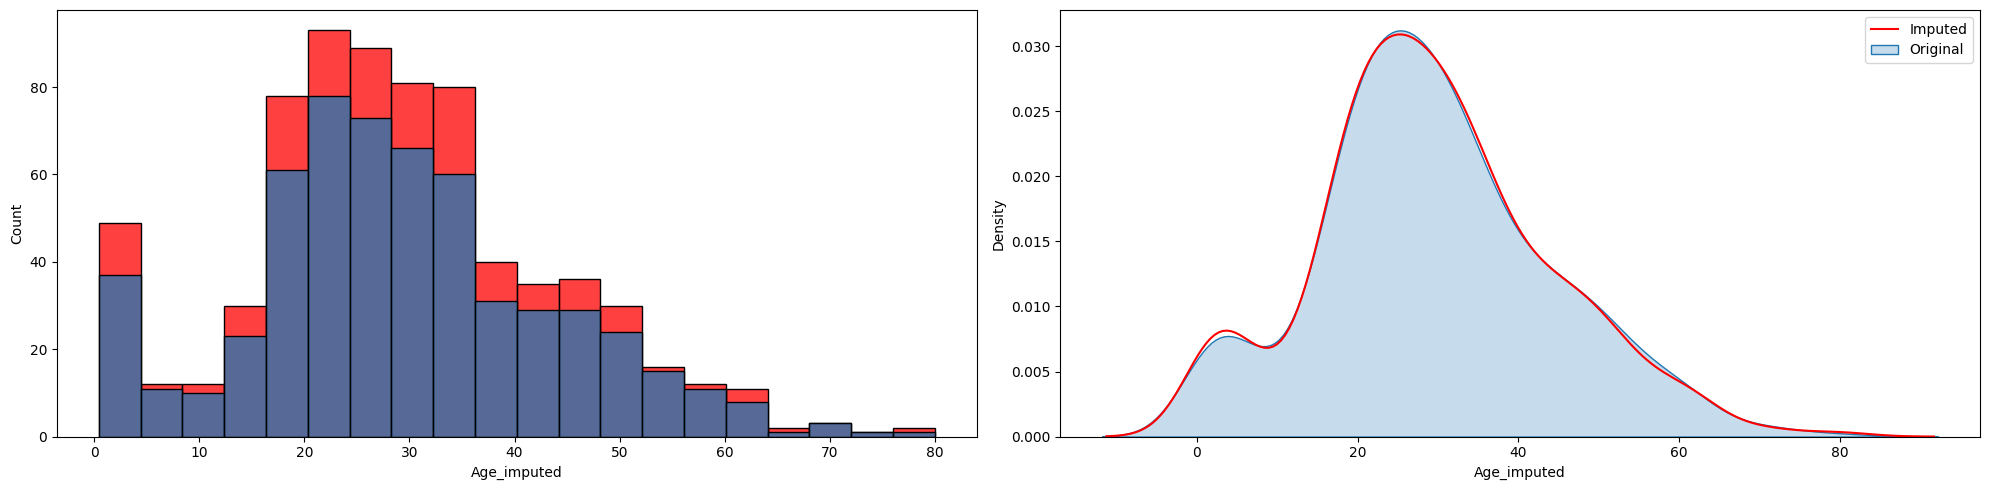

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(121)
sns.histplot(x_train['Age_imputed'], label='Imputed', color='r')
sns.histplot(x_train['Age'], label='Original')

plt.subplot(122)
sns.kdeplot(x_train['Age_imputed'], label='Imputed', color='r')
sns.kdeplot(x_train['Age'], label='Original', fill=True)

plt.legend()
plt.tight_layout()
plt.show()

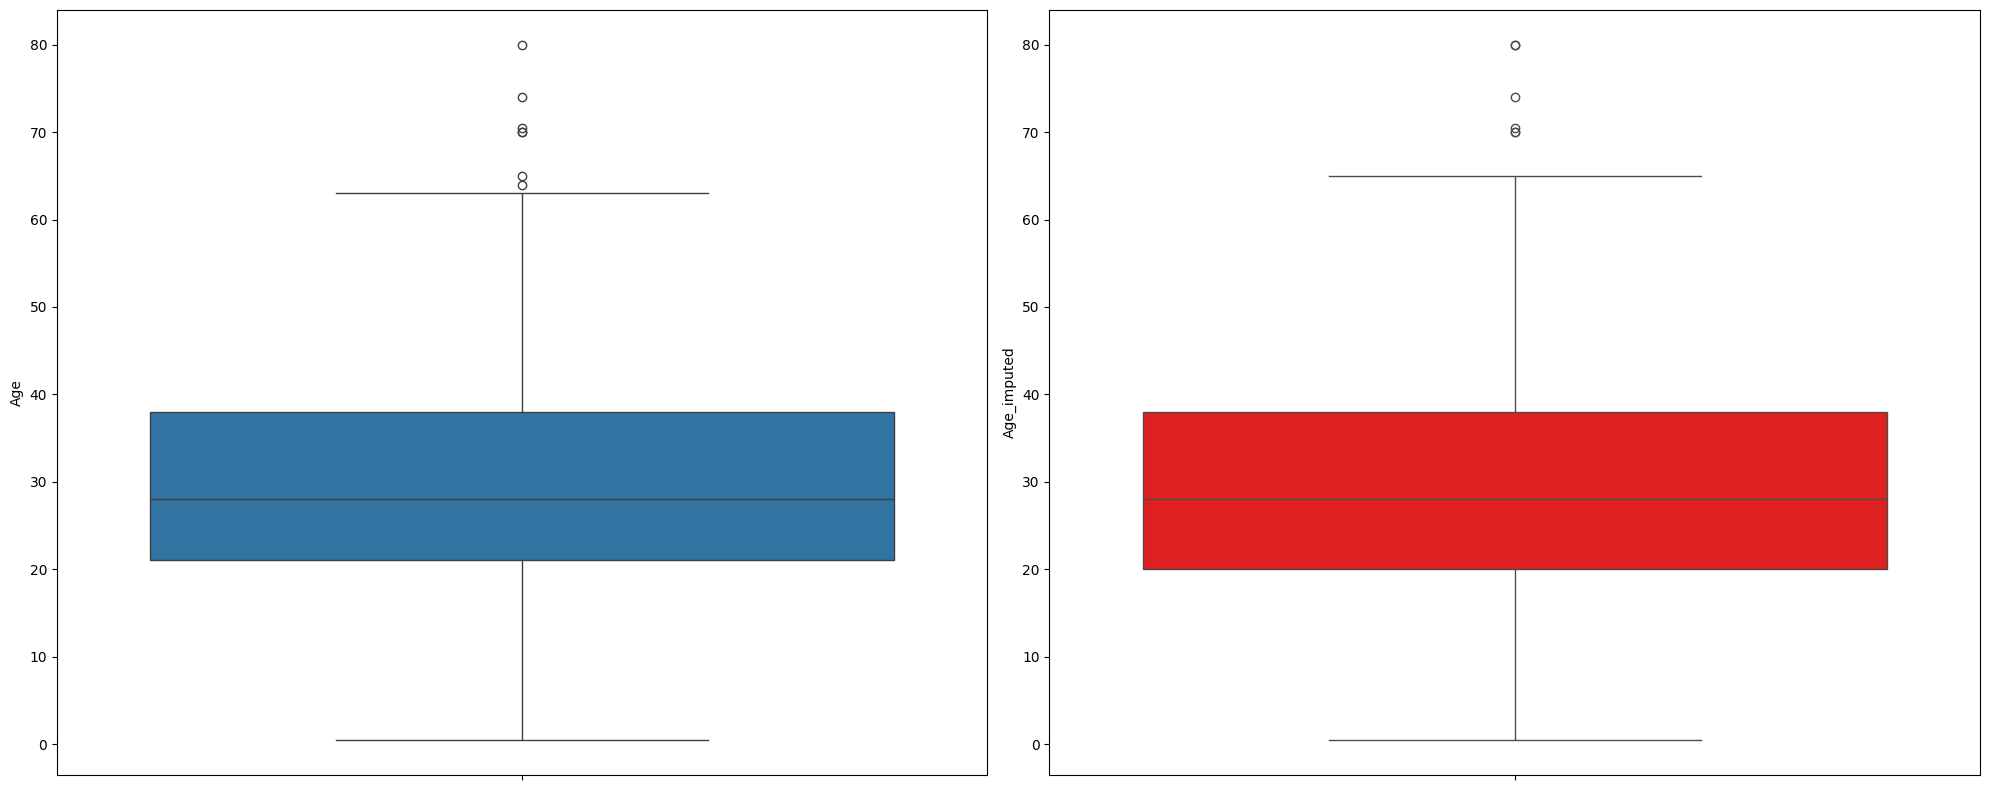

In [9]:
plt.figure(figsize=(20,8))

plt.subplot(121)
sns.boxplot(x_train['Age'])
plt.subplot(122)
sns.boxplot(x_train['Age_imputed'], color='r') 

# plt.legend()
plt.tight_layout()
plt.show()

### **Type 2**

In [10]:
# in the above imputation we have seen that how to assign a random num to the missing value, it means once a user puts fare value and dont put age value, then the machine will assign a random age value to that observation. But the issue arises when he removes that fare value and again puts the same fare value now the machine will assign a new random age value to that observation, or if he adds another fare value with no age value then the machine will assign a new random age value to that observation. It means he will keep having a different age imputed value by the machine for the same fare value.

# to prevent this we have writtem the code down below

# these are new codes for imputation 
x_train['Age_imputed'] = x_train.apply(
    lambda row: x_train['Age'].dropna().sample(1, random_state=int(row['Fare']*100)).values[0] 
    if pd.isna(row['Age']) else row['Age'],
    axis=1
)
x_test['Age_imputed'] = x_test.apply(
    lambda row: x_train['Age'].dropna().sample(1, random_state=int(row['Fare']*100)).values[0] 
    if pd.isna(row['Age']) else row['Age'],
    axis=1
)

`lambda row:`
- It means, for each row, treat that row as a variable named `row`, and apply the logic after the colon.

`x_train.apply(..., axis=1)` 
- tells Pandas to go through the dataframe row by row.
- For each step, the variable row holds the data for that specific passenger (e.g., `{'Age': NaN, 'Fare': 7.25}`).

`x_train['Age'].dropna()`
- Drops all the rows with mssing values.


`if pd.isna(row['Age']) else row['Age']`
- It checks: Is the Age missing for this person?
    - **NO**: If they have an age (e.g., 30), just return row['Age'] (30). Nothing changes.
    - **YES**: If Age is NaN, we run the special sampling code.

`sample(1, random_state=int(row['Fare']*100))`
- This is the clever part. We need to pick a random age, but we want it to be consistent.
- Picks one Age randomly from that pool.
- Fare = 7.85 → random_state = 785

`.values[0]`
- `sample(1)` returns a list with one item (e.g., [42]).
- `.values[0]` takes the number out of the list so we just get 42.

What `Age_imputed` contains ???
- Original Age for rows where Age is available.
- Deterministic imputed Age for rows where Age is missing.


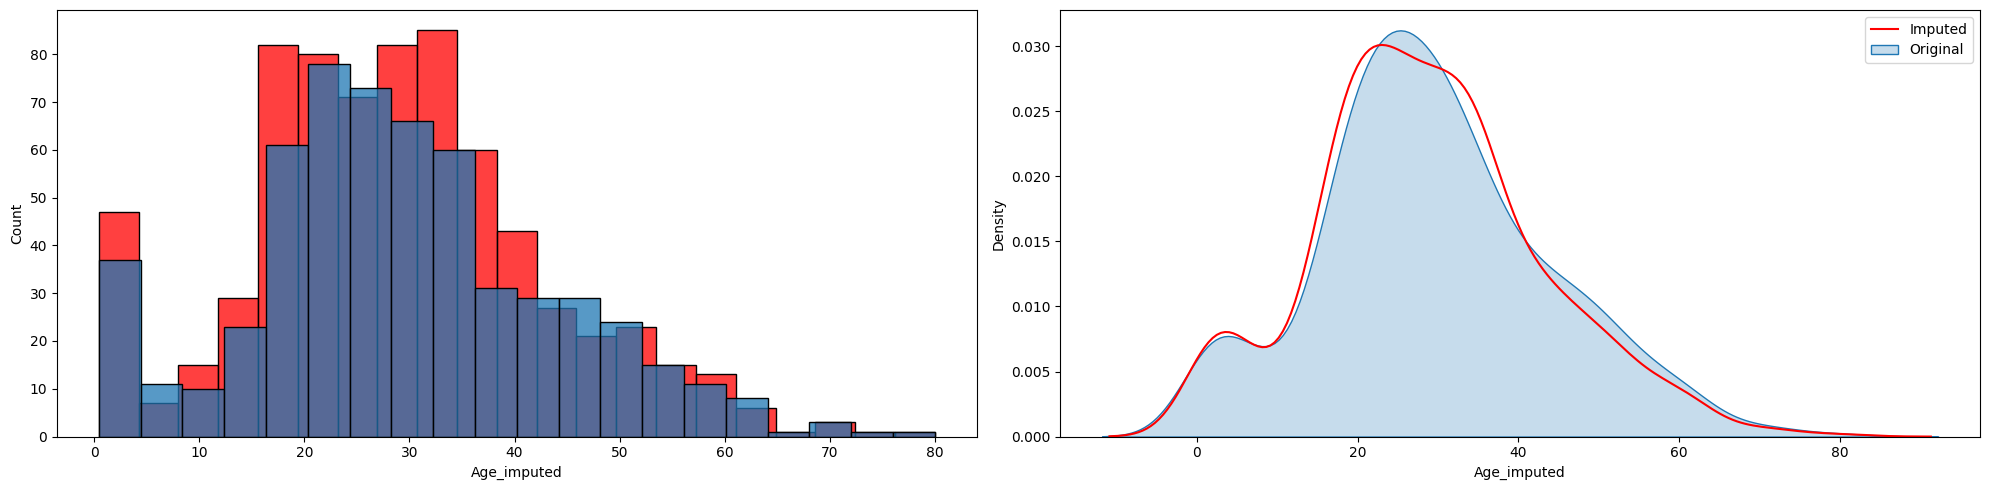

In [11]:
plt.figure(figsize=(20,5))

plt.subplot(121)
sns.histplot(x_train['Age_imputed'], label='Imputed', color='r')
sns.histplot(x_train['Age'], label='Original')

plt.subplot(122)
sns.kdeplot(x_train['Age_imputed'], label='Imputed', color='r')
sns.kdeplot(x_train['Age'], label='Original', fill=True)

plt.legend()
plt.tight_layout()
plt.show()

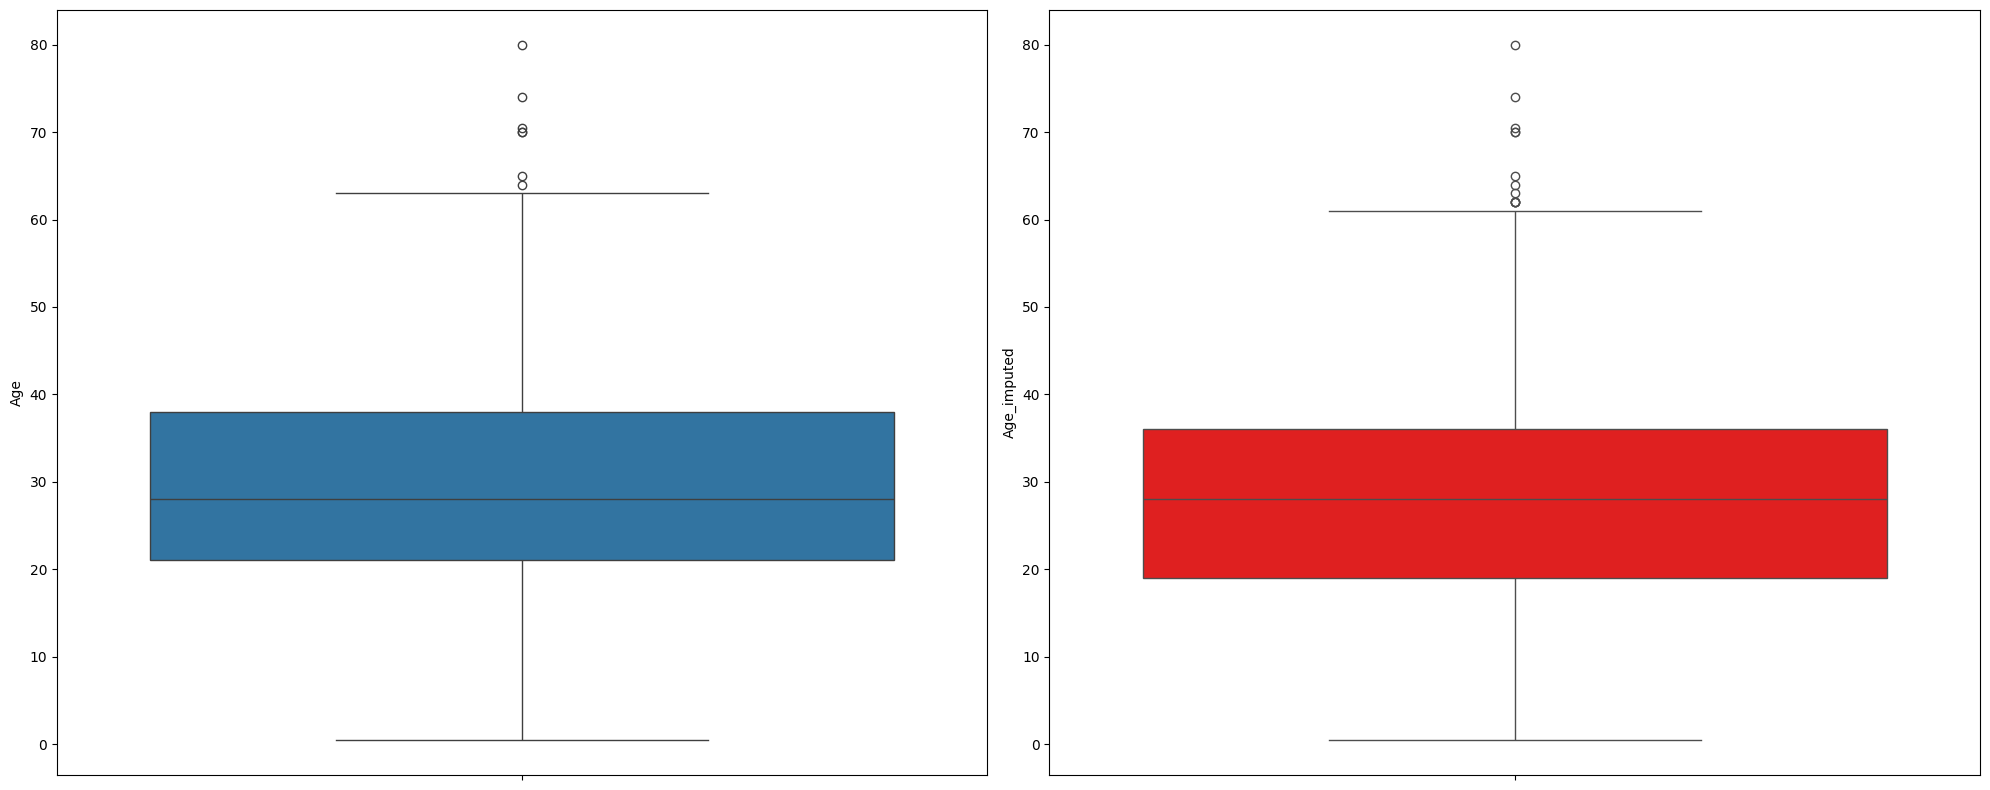

In [12]:
plt.figure(figsize=(20,8))

plt.subplot(121)
sns.boxplot(x_train['Age'])
plt.subplot(122)
sns.boxplot(x_train['Age_imputed'], color='r') 

# plt.legend()
plt.tight_layout()
plt.show()